In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np

In [43]:
def plot_image(image: np.array, color=False) :
    plt.imshow(image) if color else plt.imshow(image, cmap='gray')
    plt.axis('off')

In [44]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image('china.jpg') / 255.
flower = load_sample_image('flower.jpg') / 255.
images = np.array([china, flower])
batch, h, w, c = images.shape

In [45]:
# create 2 filters
filers = np.random.randn(5,5,c,batch) # 5,5,3,2
output = tf.nn.conv2d(images, filers, strides=1, padding='SAME')
output.shape # 3D to 2D

TensorShape([2, 427, 640, 2])

In [46]:
filers[:,:,:,0].shape # 1st filers

(5, 5, 3)

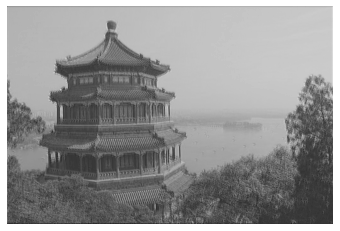

In [47]:
#ploting
plot_image(output[0,:,:,1], color=False) # plot 1st image 2nd feature map

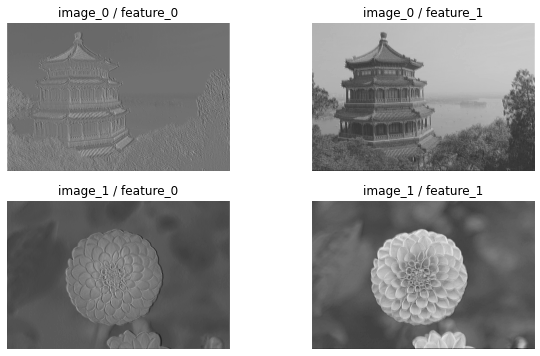

In [48]:
plt.figure(figsize=(10,6))
for image in (0,1) :
    for feature_map in (0,1) :
        plt.subplot(2,2,image*2 + feature_map+1)
        plt.title(f'image_{image} / feature_{feature_map}')
        plot_image(output[image,:,:,feature_map])


## Convolution Layer

<img src="https://docs.ecognition.com/v9.5.0/Resources/Images/ECogUsr/UG_CNN_scheme.png" />

In [49]:
tf.random.set_seed(42)
conv = tf.keras.layers.Conv2D(filters=2, kernel_size=(5,5), strides=1, padding='SAME', activation='relu', input_shape=(427, 640, 3))
conv_outputs = conv(images)
conv_outputs.shape #batch, h, w, filters

TensorShape([2, 427, 640, 2])

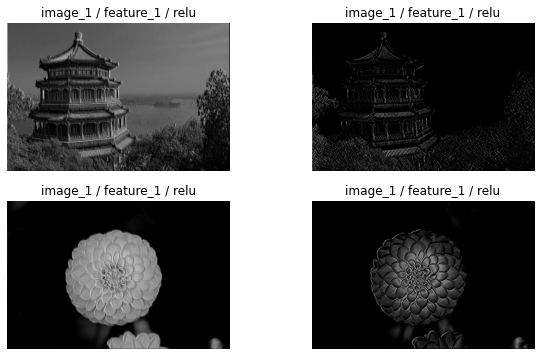

In [50]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plt.title(f'image_{image} / feature_{feature_map} / relu' )
        plot_image(conv_outputs[image_index, :, :, feature_map_index])


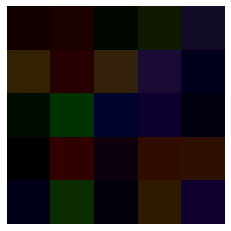

In [51]:
plot_image(tf.nn.relu(conv.weights[0][:,:,:,0])) # 1st feture map looklike

### Valid vs Same padding

<img src="https://i.stack.imgur.com/7HSXgm.png"/>

## Pooling Layers

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS4wmBObMV9VyW1liIA8mIwjzFC6l7TxHIDEjw5Oo1X1Rm_GQiuPaJFpBv1sgORjo2sSrs&usqp=CAU"/>

In [52]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
output_pool = max_pool(conv_outputs)
output_pool.shape # batch 

TensorShape([2, 213, 320, 2])

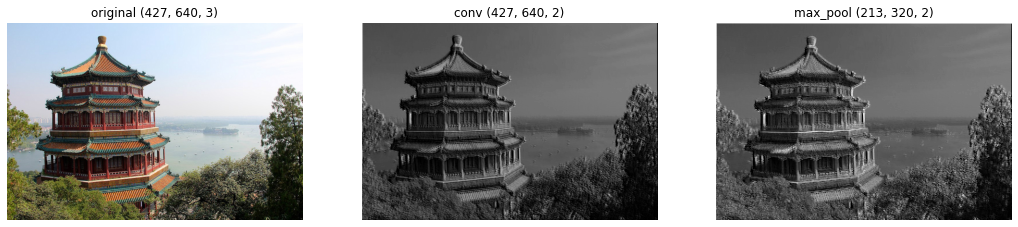

In [53]:
plt.figure(figsize=(18,6))

idx_img = 0
idx_feature = 0
plt.subplot(1,3,1)
plot_image(images[idx_img]) 
plt.title(f'original {images[0].shape}')

plt.subplot(1,3,2)
plot_image(conv_outputs[idx_img,:,:,idx_feature]) 
plt.title(f'conv {conv_outputs.shape[1:]}')

plt.subplot(1,3,3)
plot_image(output_pool[idx_img,:,:,idx_feature]) 
plt.title(f'max_pool {output_pool.shape[1:]}');

you can use more such as GlobalAvg, GlobalMax ..

<img src="https://www.researchgate.net/publication/338079465/figure/fig4/AS:905983672987648@1593014748012/The-difference-of-max-pooling-and-global-max-pooling.ppm" />

## Image manipulate

<img src="https://qph.cf2.quoracdn.net/main-qimg-10856ecbea4f439fb9fb751d41ff704a" width=300px/>

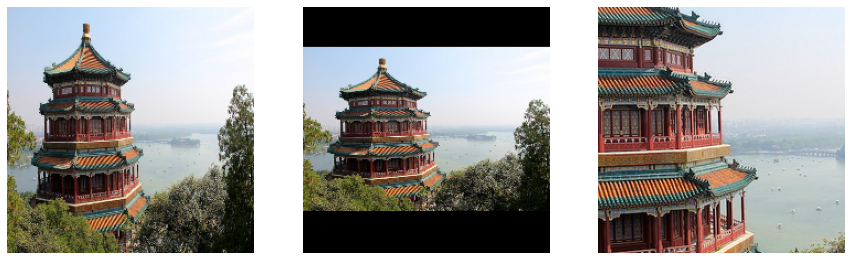

In [54]:
images_resized = tf.image.resize(images, [224,224])
images_resized_pad = tf.image.resize_with_pad(images, 224,224, antialias=False)
images_resized_crop = tf.image.resize_with_crop_or_pad(images, 224,224)

plt.figure(figsize=(15,6))
for i,image in enumerate([images_resized, images_resized_pad, images_resized_crop]) :
    plt.subplot(1,3,i+1) 
    plot_image(image[0])

## Training Models

In [55]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [56]:
class_names = info.features['label'].names
n_class = len(class_names)
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

spilting data

In [57]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

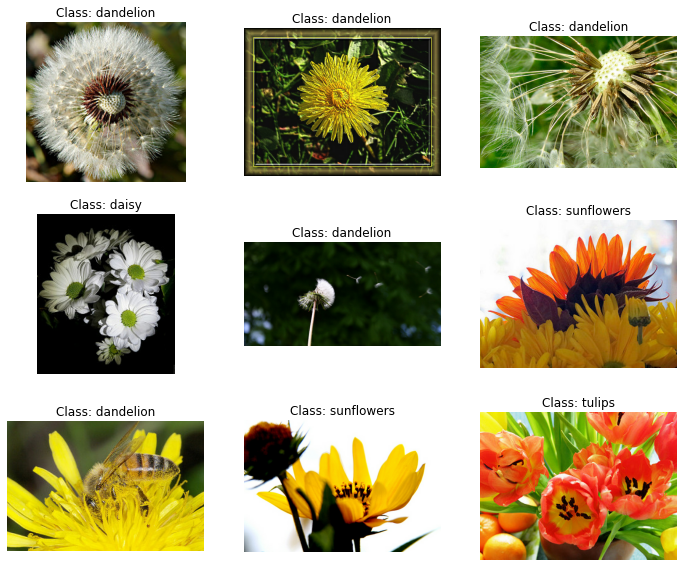

In [58]:
plt.figure(figsize=(12,10))
idx = 0
for image, label in train_set_raw.take(9) :
    idx += 1
    plt.subplot(3, 3, idx)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

Preprocessing

In [59]:
def central_crop(image) :
    shape = tf.shape(image) # (h,w,c)
    min_dim = tf.reduce_min([shape[0], shape[1]]) # find what size is shortest
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

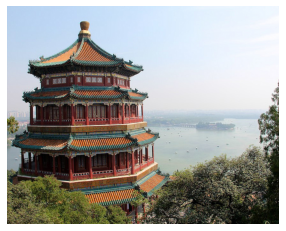

In [60]:
plot_image(central_crop(china))

In [61]:
def random_crop(image) :
    shape = tf.shape(image) # h,w,c
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 //100 # random crop 90% of image
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

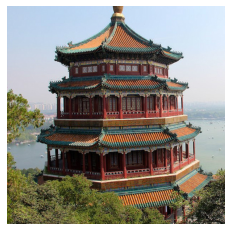

In [62]:
plot_image(random_crop(china))

In [63]:
def preprocess(image, label, randomize=False) :
    if randomize :
        croped = tf.image.random_flip_left_right(random_crop(image))
    else :
        croped = central_crop(image)
    resized = tf.image.resize(croped, [224,224])
    final_image = tf.keras.applications.xception.preprocess_input(resized)
    return final_image, label

move to dataset

In [64]:
from functools import partial

BATCH_SIZE = 32
train_set = train_set_raw.shuffle(1000).map(partial(preprocess, randomize=True)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # partial because want to set randomize to True
valid_set = valid_set_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_set = test_set_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

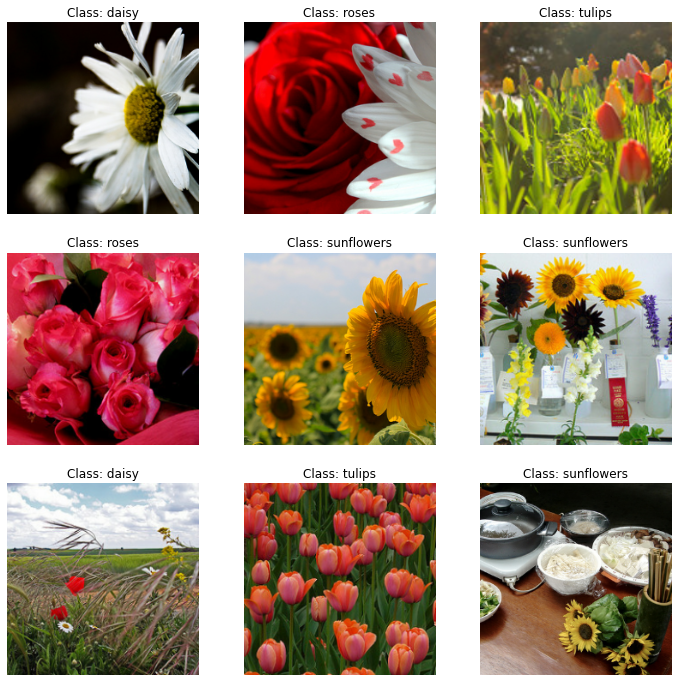

In [65]:
plt.figure(figsize=(12,12))
for x_batch, y_batch in train_set.take(1) : # take 1 batch
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(x_batch[index] / 2 + 0.5) # xception preprocessing 
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

In [66]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_class, activation="softmax")(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [67]:
for index, layer in enumerate(base_model.layers[::10]) :
    print(index, layer.name, layer.trainable)

0 input_2 True
1 block2_sepconv2 True
2 block3_sepconv2 True
3 block4_sepconv2 True
4 block5_sepconv2 True
5 block6_sepconv2 True
6 block7_sepconv2 True
7 block8_sepconv2 True
8 block9_sepconv2 True
9 block10_sepconv2 True
10 block11_sepconv2 True
11 block12_sepconv2 True
12 block13_sepconv2 True
13 block14_sepconv2_bn True


In [68]:
for layer in base_model.layers:
    layer.trainable = False

In [69]:
for index , layer in enumerate(model.layers[120:]) :
    print(index, layer.name, layer.trainable)

0 block13_sepconv2 False
1 block13_sepconv2_bn False
2 conv2d_10 False
3 block13_pool False
4 batch_normalization_7 False
5 add_23 False
6 block14_sepconv1 False
7 block14_sepconv1_bn False
8 block14_sepconv1_act False
9 block14_sepconv2 False
10 block14_sepconv2_bn False
11 block14_sepconv2_act False
12 global_average_pooling2d_1 True
13 dense_1 True


> can train only layers that we add on top

In [70]:
opitmizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opitmizer, metrics=['accuracy'])
hist = model.fit(train_set, validation_data=valid_set, epochs=1)

86/86 [==============================] - 303s 4s/step - loss: 1.7857 - accuracy: 0.7885 - val_loss: 1.2601 - val_accuracy: 0.8475


> just train a few epoch then we will unfreeze and train for longer

In [71]:
for layer in base_model.layers[-3:] : # must to unfreeze base model not model that we imprement // take too long time to train
    layer.trainable = True

for index , layer in enumerate(model.layers[120:]) :
    print(index, layer.name, layer.trainable)

0 block13_sepconv2 False
1 block13_sepconv2_bn False
2 conv2d_10 False
3 block13_pool False
4 batch_normalization_7 False
5 add_23 False
6 block14_sepconv1 False
7 block14_sepconv1_bn False
8 block14_sepconv1_act False
9 block14_sepconv2 True
10 block14_sepconv2_bn True
11 block14_sepconv2_act True
12 global_average_pooling2d_1 True
13 dense_1 True


> we unfreeze all the recompile

In [72]:
hist.epoch # previous epochs

[0]

In [73]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001) # with lower learning rate
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opitmizer, metrics=['accuracy'])
hist = model.fit(train_set, validation_data=valid_set, epochs=3, initial_epoch=len(hist.epoch))

Epoch 2/3
86/86 [==============================] - 376s 4s/step - loss: 0.9382 - accuracy: 0.8121 - val_loss: 0.8740 - val_accuracy: 0.8403
Epoch 3/3
86/86 [==============================] - 365s 4s/step - loss: 0.3040 - accuracy: 0.8968 - val_loss: 0.4387 - val_accuracy: 0.8711


## Classification and Localization

> Localizing an object in a picture can be expressed as a regression task

> to predict a bounding box around the object, a
common approach is to predict the horizontal and vertical coordinates of
the object’s center

In [81]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_class, activation='softmax')(avg)
loc_output = tf.keras.layers.Dense(4)(avg) # x an y top and bottom

model = tf.keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"], # order from output class
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy",'mse'])

> the flowers dataset does not have bounding
boxes around the flowers. So, we need to add them ourselves

but now just random it

In [84]:
def add_random_bounding_boxes(images, labels) :
    fake_box = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_box)

In [85]:
fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
fake_train_set

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [87]:
model.fit(fake_train_set,steps_per_epoch=5, epochs=2) # just 5 sample per epoch

Epoch 1/2
5/5 [==============================] - 53s 11s/step - loss: 1.2513 - dense_4_loss: 1.5050 - dense_5_loss: 0.2365 - dense_4_accuracy: 0.3625 - dense_4_mse: 4.7353 - dense_5_accuracy: 0.2250 - dense_5_mse: 0.2365
Epoch 2/2
5/5 [==============================] - 49s 10s/step - loss: 1.0536 - dense_4_loss: 1.2750 - dense_5_loss: 0.1682 - dense_4_accuracy: 0.6313 - dense_4_mse: 4.8323 - dense_5_accuracy: 0.2875 - dense_5_mse: 0.1682


In [92]:
predictions = model.predict(test_set.take(2)) # prediction only 2 batch 32*2 = 64 instances 

In [94]:
predictions[0].shape # class pred

(64, 5)

In [98]:
predictions[1].shape # box location pred 

(64, 4)

In [107]:
sample_image = []
true_label = []
for image,label in test_set.take(2).unbatch() :
    sample_image.append(image)
    true_label.append(label)
sample_image = np.array(sample_image).reshape(-1,224,224,3)
true_label = np.array(true_label).reshape(-1,1)

In [110]:
sample_image.shape, true_label.shape

((64, 224, 224, 3), (64, 1))

In [118]:
pred_class = np.argmax(predictions[0], axis=1).reshape(-1,1)
pred_class[:5]

array([[2],
       [1],
       [3],
       [3],
       [3]], dtype=int64)

In [125]:
pred_box = predictions[1]
pred_box[0]

array([1.1041429 , 0.50083536, 1.4091934 , 0.8306829 ], dtype=float32)

In [198]:
from matplotlib.patches import Rectangle

def plot_pred(id=0) :
    plot_image(sample_image[id]/2 +0.5)
    title = f'pred : {class_names[pred_class[id][0]]} - {class_names[true_label[id][0]] }'
    color = 'blue' if pred_class[id][0] == true_label[id][0] else 'red'  
    a,b,c,d = pred_box[id] *224 # re normalize
    plt.gca().add_patch(Rectangle((a,b),c,d,
                    edgecolor='black',
                    facecolor='none',
                    lw=2))  
    plt.title(title, color=color)

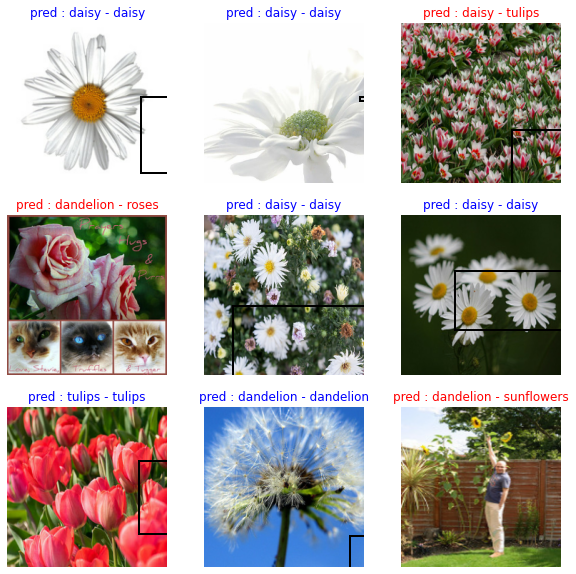

In [200]:
plt.figure(figsize=(10,10))
for i in range(9) :
    random_img = np.random.randint(0,63,size=1)[0]
    plt.subplot(3,3,i+1)
    plot_pred(random_img)

> box not good because we just random 

## Mean Average Precision (mAP)

In [201]:
def maximum_precistion(precistion):
    return np.flip(np.maximum.accumulate(np.flip(precistion)))

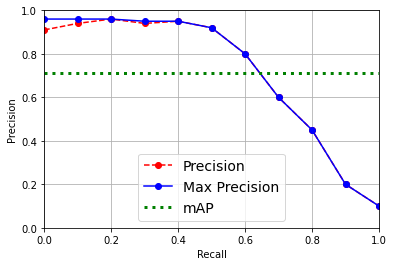

In [208]:
recalls = np.linspace(0,1,11)
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precision = maximum_precistion(precisions)
mAP = max_precision.mean()

plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precision, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14);